In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.data_processing import (
    load_dataset, 
    save_dataset,
    remove_duplicates_and_empty_rows,
    check_if_column_is_unique_per_row,
    predict_missing_values_with_linear_regression,
    get_outliers_IRQ,
    get_distinct_rows_from_dataframes,
    predict_next_month_average_ARIMA,
    predict_next_month_average_QR,
    predict_next_month_average_SW,
    BRONZE_PATH,
    SILVER_PATH,
    GOLD_PATH,
    GROUP_FILENAME,
    POSTS_FILENAME
)
from utils.data_visualization import (
    analyse_categorical_features,
    analyse_numerical_features,
    analyse_numerical_features_per_category,
    plot_correlation_matrices,
    plot_scatter_graph,
    analyse_aggregated_features_per_category,
    analyse_features_trend
)

In [2]:
posts_df_aggregated = load_dataset(GOLD_PATH + "posts_and_group_df_with_new_metrics_agg_by_date", "parquet")

## Prediction of `reach` and `clicks` for the next month:

According to the data and patterns investigation done:
- Provided data has no seasonal trend or visible patterns vary by date.
- In total `reach`, `likes`, `click` averages are correlated with average comments number per date.
- unique_reach is highly correlated with `click` and `likes`.
- `reach_growth_rate` is sligtly affected with total average of `likes` and `click`.
- There are correlations within daily average of main metrics according to Pearson and Spearman.
- `reach` and `likes` features contains a lot of outliers and are not normaly distributed in general.
- Data is stationary.

Due to this considerations Sliding Average and ARIMA are chosen to predict an average `reach` and `likes` metrics for the next month.

## 1. ARIMA Prediction:

### `AUTO_ARIMA` for parameters search:

We will try to use ARIMA to predict average `reach` per day based on existing aggregated data.

Steps that would be preformed:
- ADF test for stationarity.
- Applying `AUTO_ARIMA` for automatic parameters detection using AIC as test.
- Drawing predicted forecast for upcoming month.

#### `reach` prediction:

DF test results:
ADF Test Statistic : -9.744495283101068
p-value : 8.325512713654906e-17
#Lags Used : 0
Number of Observations Used : 90
Time series is stationary.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2072.053, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2073.875, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2074.044, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2440.399, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2075.937, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.623 seconds
0,0,0


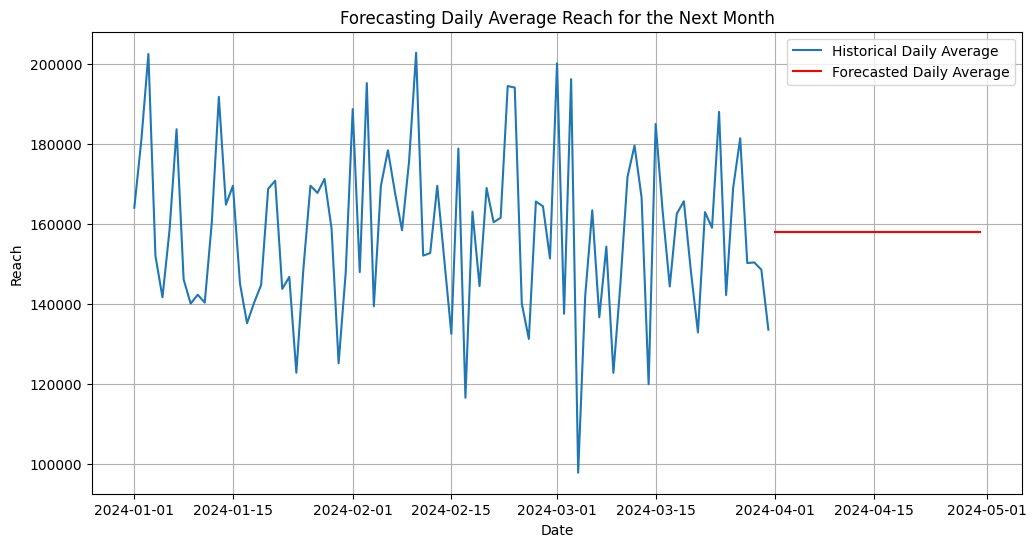

In [3]:
prediction = predict_next_month_average_ARIMA(posts_df_aggregated, 'reach', use_auto_arima=True,  information_criterion='aic')

#### `likes` prediction:

DF test results:
ADF Test Statistic : -11.209860650378907
p-value : 2.1388809284108817e-20
#Lags Used : 0
Number of Observations Used : 90
Time series is stationary.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1551.267, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1546.465, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1545.268, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1545.508, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1842.543, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1547.269, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1547.307, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1549.297, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1625.052, Time=0.00 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.235 seconds
1,0,0


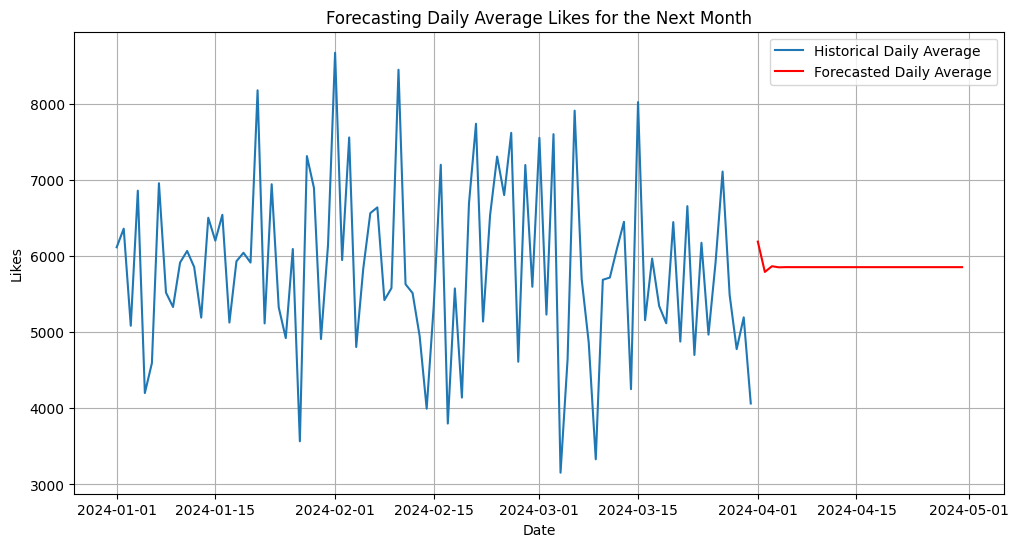

In [4]:
prediction = predict_next_month_average_ARIMA(posts_df_aggregated, 'likes', use_auto_arima=True, information_criterion='aic')

### Conclusion:

`AUTO_ARIMA` straight line prediction indicates that the model has not identified any significant autoregressive (AR), differencing (I), or moving average (MA) components in the data. It also may indicate that the data was pre-processed with excessive differencing or transformations that overly stabilize the series, the resultant series might become too random (akin to white noise).

## 2. Sliding Average Prediction:

We will try to use Simple Sliding Average to predict average `reach` and `likes` per day based on existing aggregated data.

Steps that would be preformed:
- Trying big window size.
- Trying lower window size.
- Compare moving average forecasts to determine wich window size is more approprite for data.
- Drawing predicted forecast for upcoming month.

#### `reach` prediction:

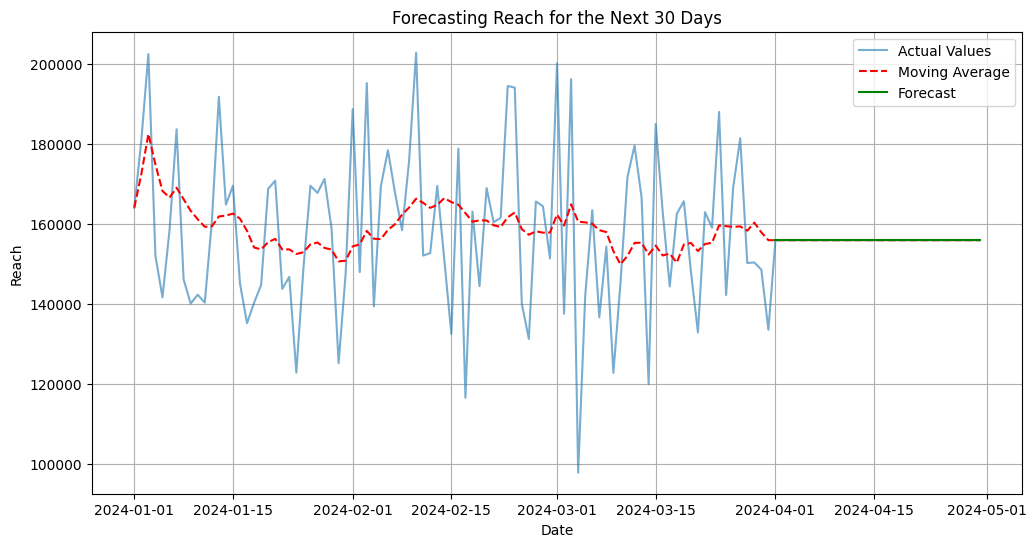

The final predicted moving average value for reach is 155857.06710627343


,reach,moving_average
2024-01-01,163968.779815,163968.779815
2024-01-02,180856.462722,172412.621269
2024-01-03,202380.138800,182401.793779
2024-01-04,151933.894766,174784.819026
2024-01-05,141582.011184,168144.257457
...,...,...
2024-04-26,155857.067106,155857.067106
2024-04-27,155857.067106,155857.067106
2024-04-28,155857.067106,155857.067106
2024-04-29,155857.067106,155857.067106


In [5]:
predict_next_month_average_SW(posts_df_aggregated, 'reach', 15)

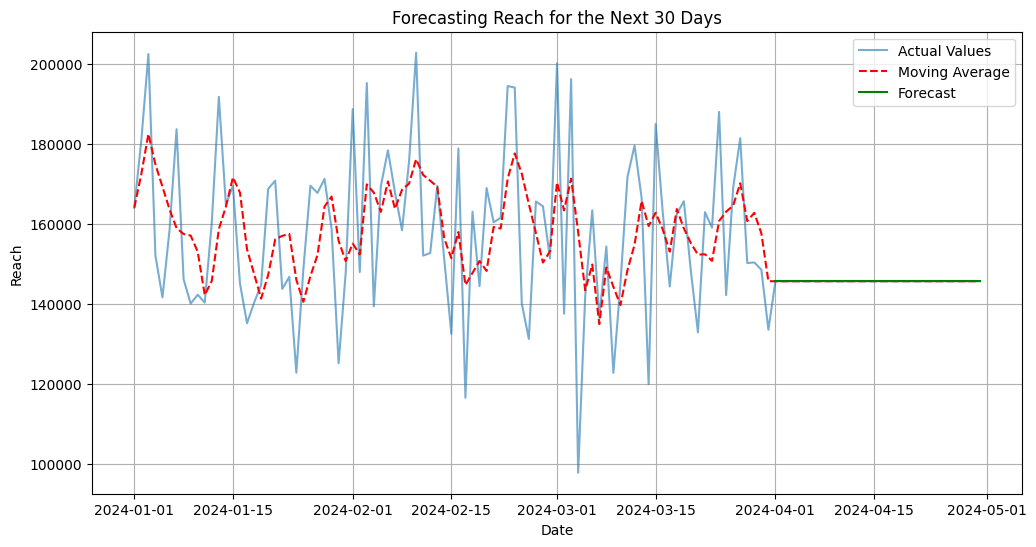

The final predicted moving average value for reach is 145605.22440970672


,reach,moving_average
2024-01-01,163968.779815,163968.779815
2024-01-02,180856.462722,172412.621269
2024-01-03,202380.138800,182401.793779
2024-01-04,151933.894766,174784.819026
2024-01-05,141582.011184,169188.126868
...,...,...
2024-04-26,145605.224410,145605.224410
2024-04-27,145605.224410,145605.224410
2024-04-28,145605.224410,145605.224410
2024-04-29,145605.224410,145605.224410


In [6]:
predict_next_month_average_SW(posts_df_aggregated, 'reach', 4)

`likes` prediction:

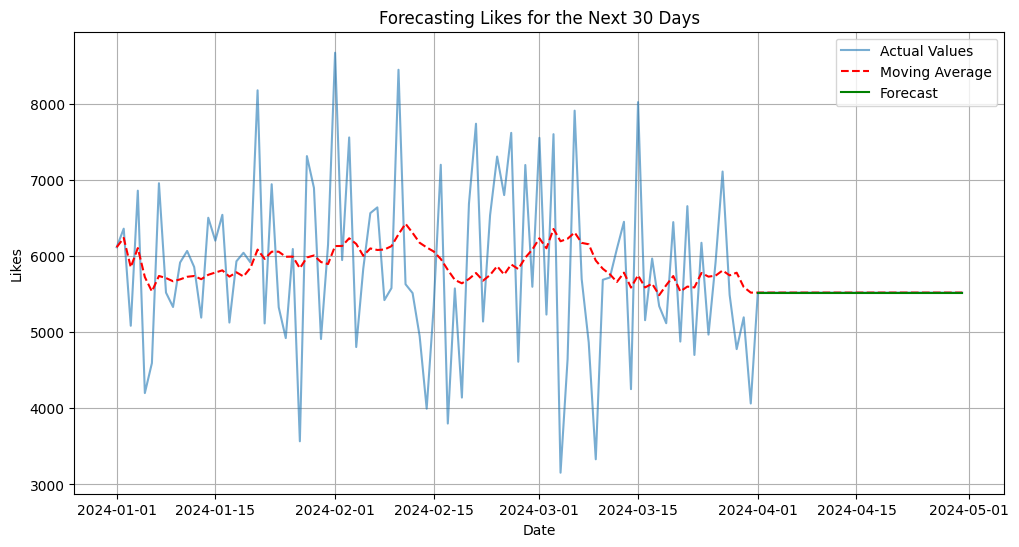

The final predicted moving average value for likes is 5518.675805368284


,likes,moving_average
2024-01-01,6113.933170,6113.933170
2024-01-02,6357.995599,6235.964385
2024-01-03,5083.343645,5851.757471
2024-01-04,6856.771378,6103.010948
2024-01-05,4200.212960,5722.451351
...,...,...
2024-04-26,5518.675805,5518.675805
2024-04-27,5518.675805,5518.675805
2024-04-28,5518.675805,5518.675805
2024-04-29,5518.675805,5518.675805


In [7]:
predict_next_month_average_SW(posts_df_aggregated, 'likes', 15)

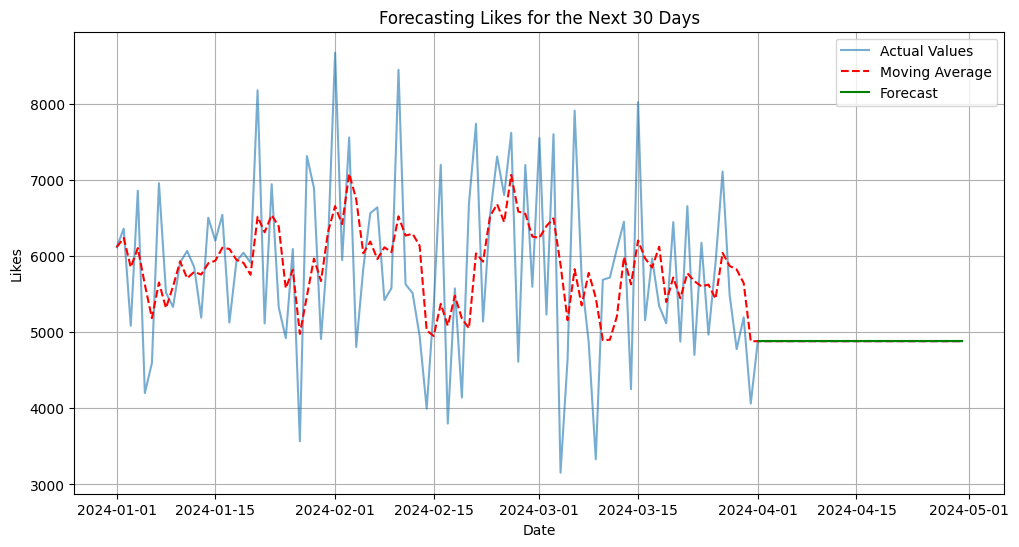

The final predicted moving average value for likes is 4880.752001976527


,likes,moving_average
2024-01-01,6113.933170,6113.933170
2024-01-02,6357.995599,6235.964385
2024-01-03,5083.343645,5851.757471
2024-01-04,6856.771378,6103.010948
2024-01-05,4200.212960,5624.580896
...,...,...
2024-04-26,4880.752002,4880.752002
2024-04-27,4880.752002,4880.752002
2024-04-28,4880.752002,4880.752002
2024-04-29,4880.752002,4880.752002


In [8]:
predict_next_month_average_SW(posts_df_aggregated, 'likes', 4)

### Conlusion:

As we can see, due to sharp decline in source data at the end of last month small window size
produces lower predicted average value. Therefore, bigger interval should be used to capture all 
trend and not to be affected by local anomalies.